In [37]:
%matplotlib inline

import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from distance import *
from mi_density import *
from utils import *

from pymatgen.core import Structure

import textalloc as ta
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import mpl_style

# Add the font file
fpath = Path("/Users/andrewf/Library/Fonts/dejavu-sans.condensed.ttf")
mpl.font_manager.fontManager.addfont(fpath)
if fpath.exists():
    # Add the font to the font manager
    mpl.font_manager.fontManager.addfont(str(fpath))
    
    # Create font properties object
    prop = mpl.font_manager.FontProperties(fname=str(fpath), size=9)
    anno_prop = mpl.font_manager.FontProperties(fname=str(fpath), size=6)
    font_name = prop.get_name()
    
    # Set as default
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [font_name]
    
    # Set specific text properties 
    # For newer matplotlib versions
    mpl.rc('font', **{'family': 'sans-serif', 'sans-serif': [font_name]})
    
    def apply_condensed_font(fig):
        for ax in fig.axes:
            # Apply to all text elements on the axes
            for text in ax.texts:
                text.set_fontproperties(anno_prop)
            
            # Apply to title and axis labels
            ax.title.set_fontproperties(prop)
            ax.xaxis.label.set_fontproperties(prop)
            ax.yaxis.label.set_fontproperties(prop)
            
            # Apply to tick labels
            for label in ax.get_xticklabels():
                label.set_fontproperties(prop)
            for label in ax.get_yticklabels():
                label.set_fontproperties(prop)
            
            # Apply to legend if it exists
            legend = ax.get_legend()
            if legend:
                # Apply to legend title
                if legend.get_title():
                    legend.get_title().set_fontproperties(prop)
                
                # Apply to legend text
                for text in legend.get_texts():
                    text.set_fontproperties(prop)


import warnings
warnings.filterwarnings("ignore")

In [38]:
MAT_DB = "perovskite_rex"

# get all cif files in folder
files = [file for file in os.listdir(MAT_DB) if ".cif" in file]

structures = []
formulas = []
space_group_numbers = []
unit_cell_vols = []
for filename in files:
    structure = Structure.from_file(os.path.join(MAT_DB, filename))
    structures.append(structure)
    formulas.append(str(structure.formula))
    space_group_numbers.append(structure.get_space_group_info()[1]) 
    unit_cell_vols.append(structure.volume)


data = pd.DataFrame({"formula": formulas, "structure": structures, "spacegroup": space_group_numbers, "volume": unit_cell_vols, "filename": files})
data['anion_class'] = data['formula'].apply(lambda x: re.sub(r'[0-9]', '', x.split(" ")[-1]))

In [39]:
data.groupby("spacegroup").size()

spacegroup
62     21
140    10
221    54
dtype: int64

      Structure  Formula A_element B_element X_element  Avg_CN2_weight  \
0    Na1 Nb1 O3   NaNbO3        Na        Nb         O        0.510473   
1     K1 Ta1 O3    KTaO3         K        Ta         O        0.511643   
2    Ba1 Sn1 O3   BaSnO3        Ba        Sn         O        0.473332   
3    Ca1 Ti1 O3   CaTiO3        Ca        Ti         O        0.521022   
4   Cs1 Cd1 Cl3  CsCdCl3        Cs        Cd        Cl        0.484875   
5     K1 Zn1 F3    KZnF3         K        Zn         F        0.510473   
6    Sr1 Nb1 O3   SrNbO3        Sr        Nb         O        0.512814   
7    Sr1 Fe1 O3   SrFeO3        Sr        Fe         O        0.490669   
8    Ba1 Mo1 O3   BaMoO3        Ba        Mo         O        0.449289   
9    Rb1 Cd1 F3   RbCdF3        Rb        Cd         F        0.506967   
10  Cs1 Hg1 Cl3  CsHgCl3        Cs        Hg        Cl        0.445877   
11  Cs1 Sn1 Br3  CsSnBr3        Cs        Sn        Br        0.437938   
12    Na1 V1 F3    NaVF3        Na    

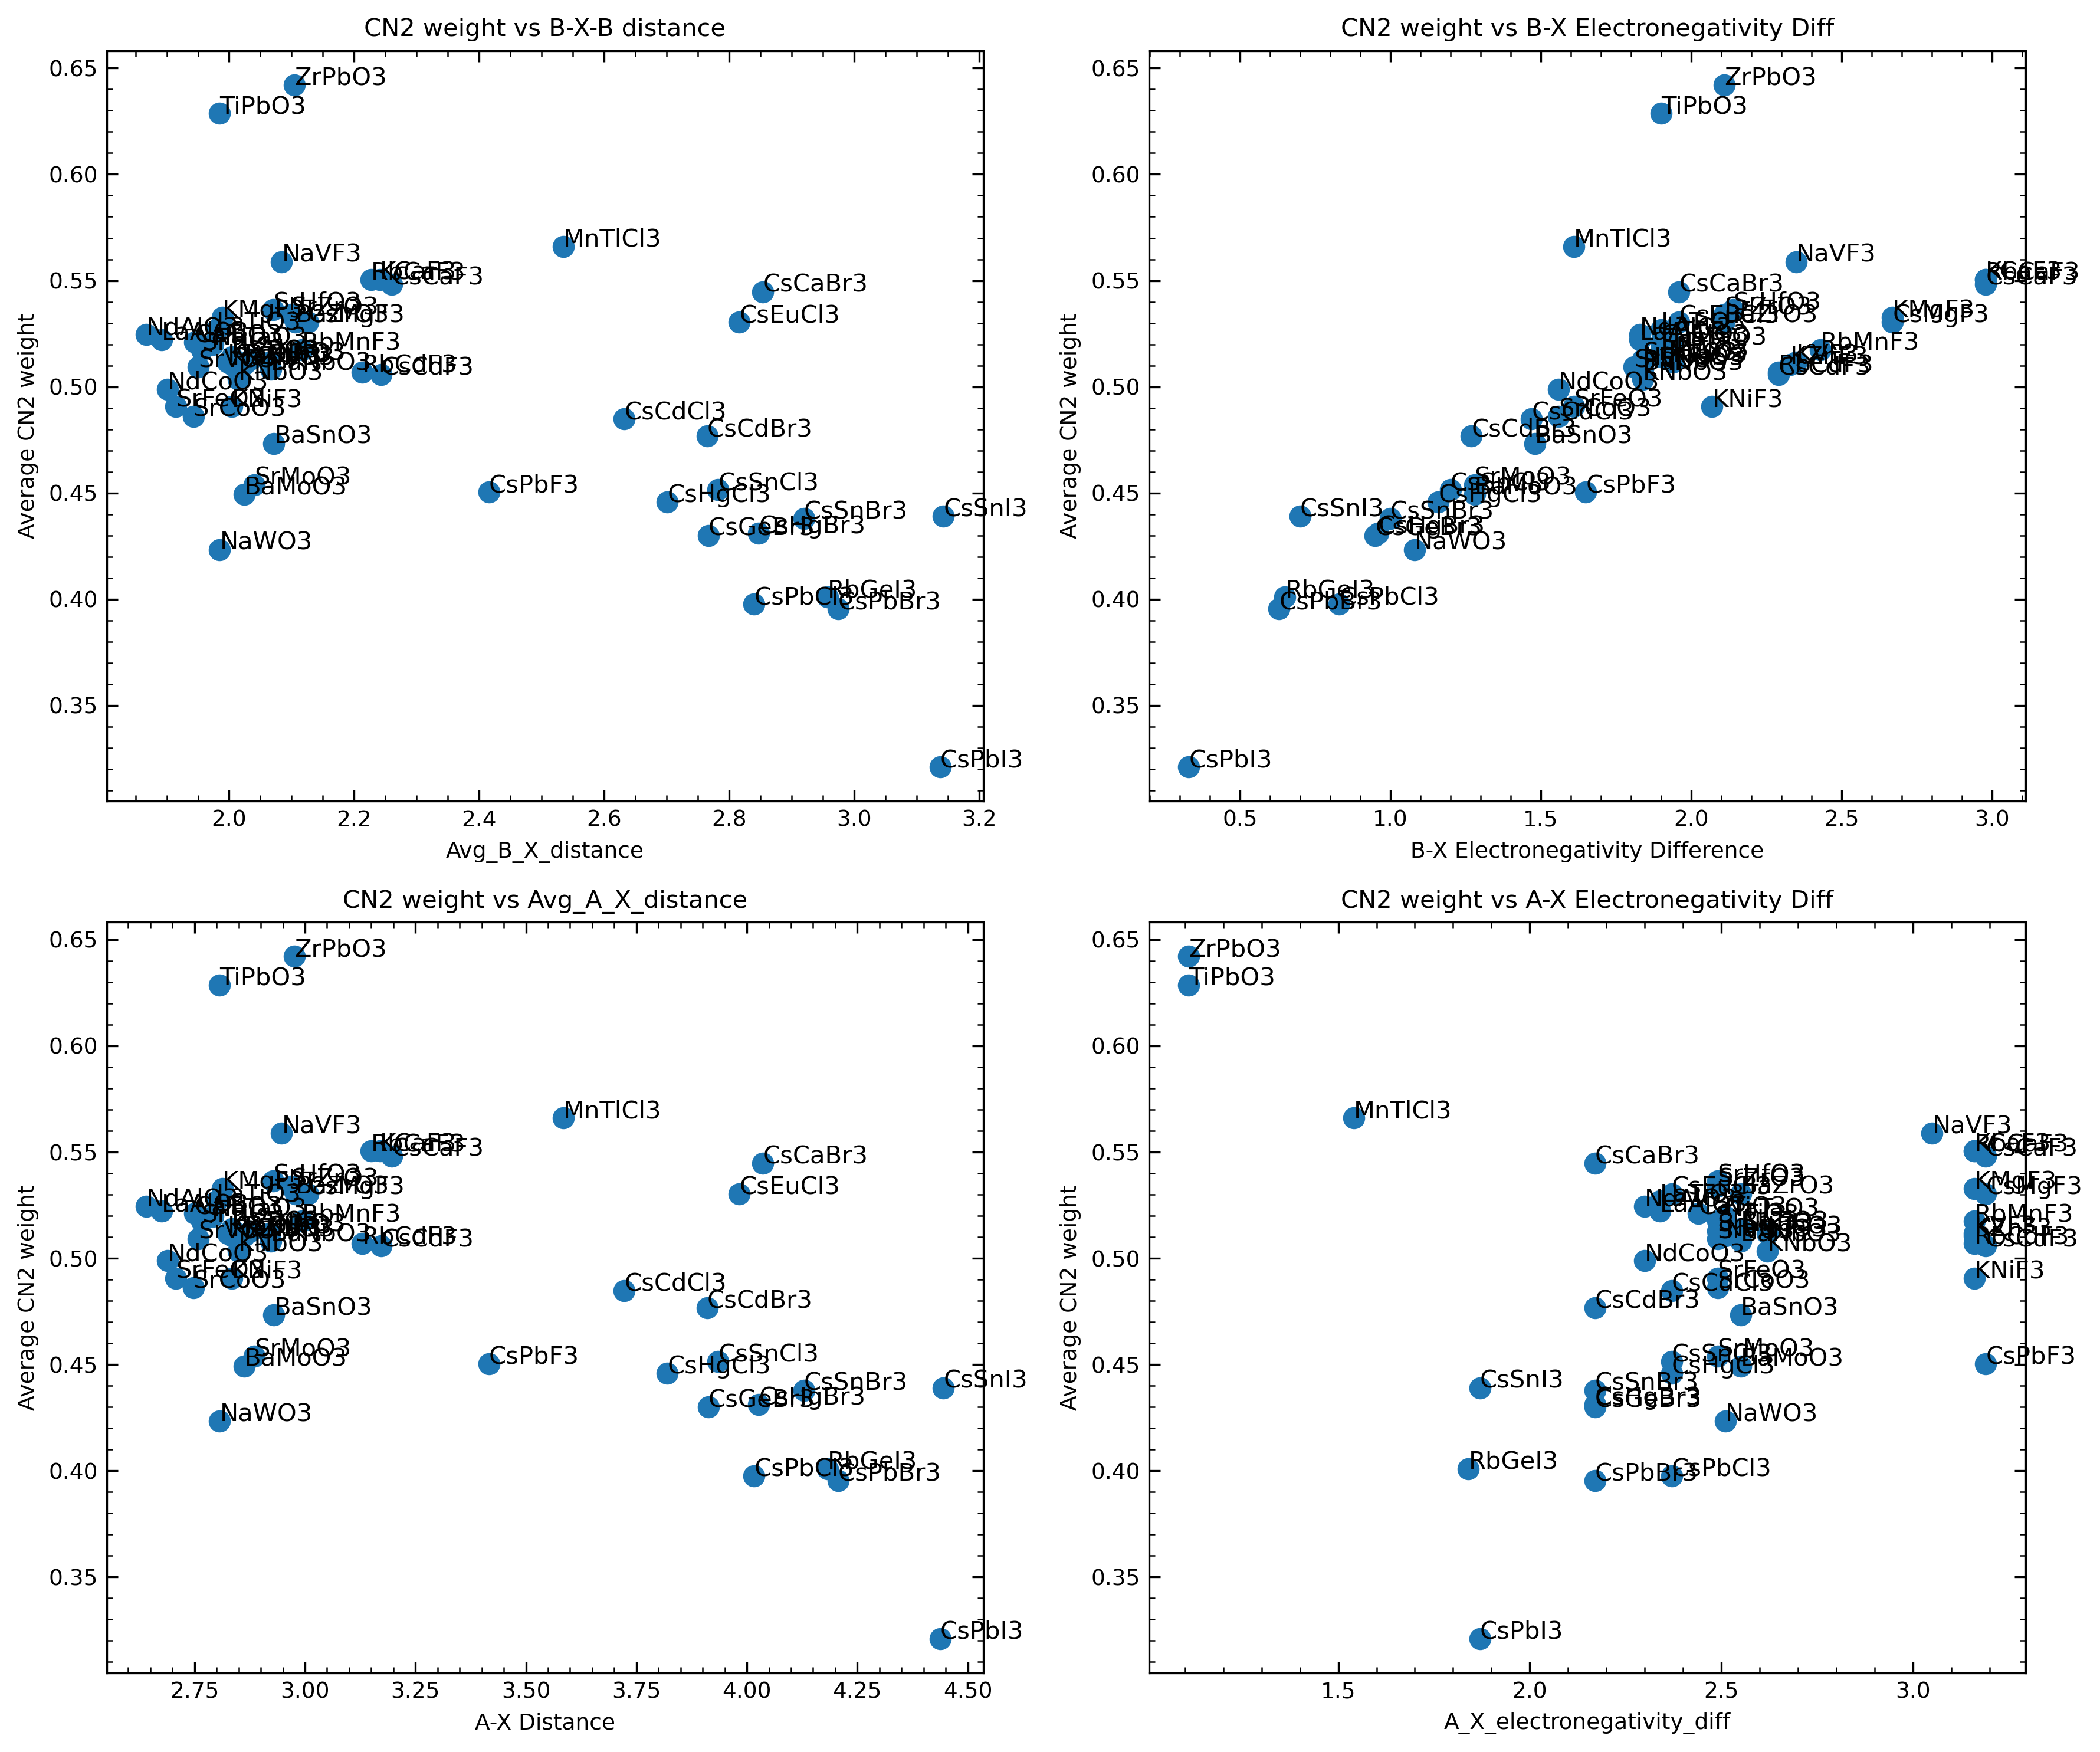

In [40]:
import numpy as np
from pymatgen.analysis.bond_valence import BVAnalyzer
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.core.periodic_table import Element
import pandas as pd
import matplotlib.pyplot as plt

def analyze_perovskite_structures(structures, structure_names=None):
    """
    Analyze a list of perovskite structures to understand coordination environments
    and explain differences in CN2 weights for anions.
    
    Args:
        structures: List of pymatgen Structure objects
        structure_names: Optional list of names for the structures
    
    Returns:
        DataFrame with analysis results
    """
    cnnf = CrystalNNFingerprint.from_preset("ops")

    if structure_names is None:
        structure_names = [f"Structure_{i}" for i in range(len(structures))]
    
    results = []
    
    # Crystal NN analyzer for coordination environment
    cnn = CrystalNN()
    
    for idx, structure in enumerate(structures):
        # Get oxidation states
        try:
            structure_with_oxi = BVAnalyzer().get_oxi_state_decorated_structure(structure)
        except:
            print(f"Warning: Could not determine oxidation states for {structure_names[idx]}")
            continue
            
        # Identify A, B, X sites
        anion_sites = [site for site in structure_with_oxi.sites if site.specie.oxi_state < 0]
        cation_sites = [site for site in structure_with_oxi.sites if site.specie.oxi_state > 0]
        
        # Sort cations based on minimum distance to anions to identify A and B cations
        sorted_cations = sorted(
            set([site.specie.element.symbol for site in cation_sites]), 
            key=lambda cat: min([
                structure_with_oxi.get_distance(
                    structure_with_oxi.sites.index(cat_site), 
                    structure_with_oxi.sites.index(an_site)
                ) 
                for cat_site in cation_sites if cat_site.specie.element.symbol == cat 
                for an_site in anion_sites
            ])
        )
        
        # B cation is closest to anions, A cation is furthest
        b_element = sorted_cations[0]
        a_element = sorted_cations[-1]
        x_element = anion_sites[0].specie.element.symbol
        
        # Get site indices for each element type
        a_indices = [i for i, site in enumerate(structure_with_oxi.sites) 
                    if site.specie.element.symbol == a_element]
        b_indices = [i for i, site in enumerate(structure_with_oxi.sites) 
                    if site.specie.element.symbol == b_element]
        x_indices = [i for i, site in enumerate(structure_with_oxi.sites) 
                    if site.specie.element.symbol == x_element]
        
        # Calculate B-X-B angles
        b_x_b_angles = []
        for x_idx in x_indices:
            x_site = structure_with_oxi.sites[x_idx]
            
            # Find the nearest B neighbors
            neighbors = cnn.get_nn_info(structure_with_oxi, x_idx)
            b_neighbors = [n for n in neighbors if structure_with_oxi.sites[n['site_index']].specie.element.symbol == b_element]
            
            # If we have at least 2 B neighbors, calculate the angles
            if len(b_neighbors) >= 2:
                for i in range(len(b_neighbors)):
                    for j in range(i+1, len(b_neighbors)):
                        b1 = structure_with_oxi.sites[b_neighbors[i]['site_index']].coords
                        b2 = structure_with_oxi.sites[b_neighbors[j]['site_index']].coords
                        
                        # Calculate vectors from X to each B
                        v1 = b1 - x_site.coords
                        v2 = b2 - x_site.coords
                        
                        # Calculate angle in degrees
                        dot_product = np.dot(v1, v2)
                        norm_v1 = np.linalg.norm(v1)
                        norm_v2 = np.linalg.norm(v2)
                        
                        if norm_v1 * norm_v2 > 0:
                            cos_angle = dot_product / (norm_v1 * norm_v2)
                            # Clamp to valid range due to floating point errors
                            cos_angle = max(min(cos_angle, 1.0), -1.0)
                            angle = np.degrees(np.arccos(cos_angle))
                            b_x_b_angles.append(angle)
        
        # Calculate average B-X and A-X bond distances
        b_x_distances = []
        for b_idx in b_indices:
            for x_idx in x_indices:
                b_x_distances.append(structure_with_oxi.get_distance(b_idx, x_idx))
        
        a_x_distances = []
        for a_idx in a_indices:
            for x_idx in x_indices:
                a_x_distances.append(structure_with_oxi.get_distance(a_idx, x_idx))
        
        # Get CN2 weight values for X anions
        x_cn2_weights = []
        for x_idx in x_indices:
            n_sites = len(structure)
            feat = cnnf.featurize(structure, n_sites-1)
            x_cn2_weights.append(feat[2])

        # Get electronegativity values
        a_element_obj = Element(a_element)
        b_element_obj = Element(b_element)
        x_element_obj = Element(x_element)
        
        a_electronegativity = a_element_obj.X
        b_electronegativity = b_element_obj.X
        x_electronegativity = x_element_obj.X
        
        # Calculate electronegativity differences
        a_x_diff = abs(a_electronegativity - x_electronegativity)
        b_x_diff = abs(b_electronegativity - x_electronegativity)
        
        # Get average values
        avg_b_x_b_angle = np.mean(b_x_b_angles) if b_x_b_angles else None
        std_b_x_b_angle = np.std(b_x_b_angles) if b_x_b_angles else None
        avg_b_x_distance = np.mean(b_x_distances) if b_x_distances else None
        avg_a_x_distance = np.mean(a_x_distances) if a_x_distances else None
        avg_cn2_weight = np.mean(x_cn2_weights) if x_cn2_weights else None
        
        # Calculate distance ratio (A-X/B-X) which relates to tolerance factor
        distance_ratio = avg_a_x_distance / avg_b_x_distance if (avg_a_x_distance and avg_b_x_distance) else None
        
        # Goldschmidt tolerance factor approximation from distances
        tolerance_factor = avg_a_x_distance / (np.sqrt(2) * avg_b_x_distance) if (avg_a_x_distance and avg_b_x_distance) else None
        
        # Store results
        result = {
            'Structure': structure_names[idx],
            'Formula': structure.composition.reduced_formula,
            'A_element': a_element,
            'B_element': b_element,
            'X_element': x_element,
            'Avg_CN2_weight': avg_cn2_weight,
            'Avg_B_X_B_angle': avg_b_x_b_angle,
            'Std_B_X_B_angle': std_b_x_b_angle,
            'Avg_B_X_distance': avg_b_x_distance,
            'Avg_A_X_distance': avg_a_x_distance,
            'A_X_electronegativity_diff': a_x_diff,
            'B_X_electronegativity_diff': b_x_diff,
            'Distance_ratio': distance_ratio,
            'Tolerance_factor': tolerance_factor
        }
        results.append(result)
    
    return pd.DataFrame(results)

def plot_cn2_correlations(df):
    """
    Create scatter plots to visualize correlations between CN2 weights and
    other structural parameters.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot CN2 weight vs B-X-B angle
    axs[0, 0].scatter(df['Avg_B_X_distance'], df['Avg_CN2_weight'])
    axs[0, 0].set_xlabel('Avg_B_X_distance')
    axs[0, 0].set_ylabel('Average CN2 weight')
    axs[0, 0].set_title('CN2 weight vs B-X-B distance')
    for i, txt in enumerate(df['Formula']):
        axs[0, 0].annotate(txt, (df['Avg_B_X_distance'].iloc[i], df['Avg_CN2_weight'].iloc[i]))
    
    # Plot CN2 weight vs B-X electronegativity difference
    axs[0, 1].scatter(df['B_X_electronegativity_diff'], df['Avg_CN2_weight'])
    axs[0, 1].set_xlabel('B-X Electronegativity Difference')
    axs[0, 1].set_ylabel('Average CN2 weight')
    axs[0, 1].set_title('CN2 weight vs B-X Electronegativity Diff')
    for i, txt in enumerate(df['Formula']):
        axs[0, 1].annotate(txt, (df['B_X_electronegativity_diff'].iloc[i], df['Avg_CN2_weight'].iloc[i]))
    
    # Plot CN2 weight vs distance ratio
    axs[1, 0].scatter(df['Avg_A_X_distance'], df['Avg_CN2_weight'])
    axs[1, 0].set_xlabel('A-X Distance')
    axs[1, 0].set_ylabel('Average CN2 weight')
    axs[1, 0].set_title('CN2 weight vs Avg_A_X_distance')
    for i, txt in enumerate(df['Formula']):
        axs[1, 0].annotate(txt, (df['Avg_A_X_distance'].iloc[i], df['Avg_CN2_weight'].iloc[i]))
    
    # Plot CN2 weight vs tolerance factor
    axs[1, 1].scatter(df['A_X_electronegativity_diff'], df['Avg_CN2_weight'])
    axs[1, 1].set_xlabel('A_X_electronegativity_diff')
    axs[1, 1].set_ylabel('Average CN2 weight')
    axs[1, 1].set_title('CN2 weight vs A-X Electronegativity Diff')
    for i, txt in enumerate(df['Formula']):
        axs[1, 1].annotate(txt, (df['A_X_electronegativity_diff'].iloc[i], df['Avg_CN2_weight'].iloc[i]))
    
    plt.tight_layout()
    return fig

# Example usage:
# structures = [structure1, structure2, ...]
# structure_names = ["CaTiO3", "SrTiO3", ...]

structures = data[data['spacegroup']==221]['structure'].tolist()
structure_names = data[data['spacegroup']==221]['formula'].tolist()
results_df = analyze_perovskite_structures(structures, structure_names)
print(results_df)
fig = plot_cn2_correlations(results_df)
plt.show()

In [41]:
results_df

,Structure,Formula,A_element,B_element,X_element,Avg_CN2_weight,Avg_B_X_B_angle,Std_B_X_B_angle,Avg_B_X_distance,Avg_A_X_distance,A_X_electronegativity_diff,B_X_electronegativity_diff,Distance_ratio,Tolerance_factor
0,Na1 Nb1 O3,NaNbO3,Na,Nb,O,0.510473,0.0,0.0,2.004668,2.835028,2.51,1.84,1.414214,1.0
1,K1 Ta1 O3,KTaO3,K,Ta,O,0.511643,0.0,0.0,1.997441,2.824808,2.62,1.94,1.414214,1.0
2,Ba1 Sn1 O3,BaSnO3,Ba,Sn,O,0.473332,0.0,0.0,2.071733,2.929872,2.55,1.48,1.414214,1.0
3,Ca1 Ti1 O3,CaTiO3,Ca,Ti,O,0.521022,0.0,0.0,1.944735,2.750271,2.44,1.90,1.414214,1.0
4,Cs1 Cd1 Cl3,CsCdCl3,Cs,Cd,Cl,0.484875,0.0,0.0,2.632201,3.722494,2.37,1.47,1.414214,1.0
5,K1 Zn1 F3,KZnF3,K,Zn,F,0.510473,0.0,0.0,2.023708,2.861956,3.16,2.33,1.414214,1.0
6,Sr1 Nb1 O3,SrNbO3,Sr,Nb,O,0.512814,0.0,0.0,2.034845,2.877705,2.49,1.84,1.414214,1.0
7,Sr1 Fe1 O3,SrFeO3,Sr,Fe,O,0.490669,0.0,0.0,1.914407,2.707380,2.49,1.61,1.414214,1.0
8,Ba1 Mo1 O3,BaMoO3,Ba,Mo,O,0.449289,0.0,0.0,2.024200,2.862651,2.55,1.28,1.414214,1.0
9,Rb1 Cd1 F3,RbCdF3,Rb,Cd,F,0.506967,0.0,0.0,2.212490,3.128934,3.16,2.29,1.414214,1.0


In [42]:
100*data.groupby(['anion_class']).size()/len(data)
# 100*data.groupby(['spacegroup']).size()/len(data)

anion_class
Br     8.235294
Cl     9.411765
F     27.058824
I      4.705882
O     50.588235
dtype: float64

In [43]:
use_precomputed = True

if use_precomputed:
    lostop_dm = np.load(f"precomputed/{MAT_DB}_lostop_dm.npy")
    elmd_dm = np.load(f"precomputed/{MAT_DB}_elmd_dm.npy")
else:
    lostop_dm = get_lostop_dm(data["structure"].values)
    np.save(f"precomputed/{MAT_DB}_lostop_dm.npy", lostop_dm)

    elmd_dm = get_elmd_dm(data["formula"].values)
    np.save(f"precomputed/{MAT_DB}_elmd_dm.npy", elmd_dm)

In [44]:
from pymatgen.analysis.bond_valence import BVAnalyzer
data[data['formula'].str.contains("I")]
# data.loc[25]
# np.argsort(lostop_dm[72])

# data['structure'].loc[59].sites
sites = data['structure'].loc[72].sites

def calculate_tolerance_factor(data, index):

    sites = data['structure'].loc[index].sites
    # elements = re.findall(r'([A-Z][a-z]*)', data.loc[index, 'formula'])

    structure_with_oxi = BVAnalyzer().get_oxi_state_decorated_structure(data['structure'].loc[index])
    anion_sites = [site for site in structure_with_oxi.sites if site.specie.oxi_state < 0]
    cation_sites = [site for site in structure_with_oxi.sites if site.specie.oxi_state > 0]
    a_element, b_element, x_element = sorted(set([site.specie.element.symbol for site in cation_sites]), key=lambda cat: min([structure_with_oxi.get_distance(structure_with_oxi.sites.index(cat_site), structure_with_oxi.sites.index(an_site)) for cat_site in cation_sites if cat_site.specie.element.symbol == cat for an_site in anion_sites]))[-1], sorted(set([site.specie.element.symbol for site in cation_sites]), key=lambda cat: min([structure_with_oxi.get_distance(structure_with_oxi.sites.index(cat_site), structure_with_oxi.sites.index(an_site)) for cat_site in cation_sites if cat_site.specie.element.symbol == cat for an_site in anion_sites]))[0], anion_sites[0].specie.element.symbol

    elements = [a_element, b_element, x_element]

    radii = {
        elements[0]: 0.0,  # A
        elements[1]: 0.0,  # B
        elements[2]: 0.0,  # X
    }
    
    for site in sites[:3]:
        site_elem = ''.join(char for char in site.species_string if char.isalpha())
        if site_elem == "Sn":
            radii[site_elem] = 1.18 # Sn2+
        else:
            try:
                radii[site_elem] = site.specie.ionic_radius
            except:
                print(f"Failed for {site_elem}")
    
    tolerance_factor = (radii[elements[0]] + radii[elements[2]]) / (np.sqrt(2) * (radii[elements[1]] + radii[elements[2]]))
    A_X_electronegativity_diff = abs(Element(a_element).X - Element(x_element).X)
    B_X_electronegativity_diff = abs(Element(b_element).X - Element(x_element).X)
    
    return tolerance_factor, A_X_electronegativity_diff, B_X_electronegativity_diff

tfs = []
A_X_diffs = []
B_X_diffs = []
for index in range(len(data)):
    try:
        tf, A_X_diff, B_X_diff = calculate_tolerance_factor(data, index)
        tfs.append(float(tf))
        A_X_diffs.append(A_X_diff)
        B_X_diffs.append(B_X_diff)
    except Exception as e:
        print(e)
        print(f"Failed for index {data['formula'].loc[index]}")
        tfs.append(np.nan)
        A_X_diffs.append(np.nan)
        B_X_diffs.append(np.nan)

data['tolerance_factor'] = tfs
data['A_X_ediff'] = A_X_diffs
data['B_X_ediff'] = B_X_diffs


Structure contains elements not in set of BV parameters: {Element Au}
Failed for index Cs1 Au1 Cl3


spglib: Attempt 0 tolerance = 1.000000e-01 failed(line 800, /private/var/folders/mr/t_bgg1cx77d83fh1txvc1j1r0000gn/T/pip-install-k1bpfcdb/spglib_db8eb978afd54791998d3a71d20f9921/src/spacegroup.c).
spglib: Attempt 1 tolerance = 9.500000e-02 failed(line 800, /private/var/folders/mr/t_bgg1cx77d83fh1txvc1j1r0000gn/T/pip-install-k1bpfcdb/spglib_db8eb978afd54791998d3a71d20f9921/src/spacegroup.c).
spglib: Attempt 2 tolerance = 9.025000e-02 failed(line 800, /private/var/folders/mr/t_bgg1cx77d83fh1txvc1j1r0000gn/T/pip-install-k1bpfcdb/spglib_db8eb978afd54791998d3a71d20f9921/src/spacegroup.c).
spglib: Attempt 3 tolerance = 8.573750e-02 failed(line 800, /private/var/folders/mr/t_bgg1cx77d83fh1txvc1j1r0000gn/T/pip-install-k1bpfcdb/spglib_db8eb978afd54791998d3a71d20f9921/src/spacegroup.c).
spglib: Attempt 4 tolerance = 8.145062e-02 failed(line 800, /private/var/folders/mr/t_bgg1cx77d83fh1txvc1j1r0000gn/T/pip-install-k1bpfcdb/spglib_db8eb978afd54791998d3a71d20f9921/src/spacegroup.c).
spglib: Attempt

In [45]:
# Get the features and fingerprint of the reference compound (idx=59)
# idx = 72 # CsAuCl3
# idx = 59 # CsPbI3
idx = 72 # CsPbI3
print(f"Reference compound formula: {data.loc[idx, 'formula']}")
reference_fp, reference_feats = process_structure(0, data.loc[idx, "structure"])

# Find 10 nearest neighbors
nearest = np.argsort(lostop_dm[idx])[1:50]

# Initialize lists to store differences
feature_diffs = []
neighbor_info = []
neighbor_fps = []

# Compare each neighbor with the reference
for neighbor in nearest:
    # Get neighbor fingerprint
    neighbor_fp, neighbor_feats = process_structure(0, data.loc[neighbor, "structure"])
    neighbor_info.append((neighbor, data.loc[neighbor, "formula"]))
    
    # Calculate absolute differences for each feature
    diffs = np.array(reference_fp) - np.array(neighbor_fp)
    feature_diffs.append(diffs)

# Convert to numpy array for easier manipulation
feature_diffs = np.array(feature_diffs)

# Calculate average difference for each feature across all neighbors
avg_diffs = np.mean(feature_diffs, axis=0)

# Get indices of features sorted by average difference (largest first)
sorted_feature_indices = np.argsort(avg_diffs)[::-1]

# Print the features with the largest differences
print("\nFeatures with largest differences between reference and neighbors:")
print(f"Reference compound {idx}: {data.loc[idx, 'formula']}")

for i, feat_idx in enumerate(sorted_feature_indices[:5]):
    print(f"\n{i+1}. Feature {reference_feats[feat_idx]}: Average difference = {avg_diffs[feat_idx]:.4f}")
    print(f"   Reference value: {reference_fp[feat_idx]}")
    print("   Neighbor values:")
    for j, (neighbor, formula) in enumerate(neighbor_info[:5]):
        print(f"      {formula} (ID: {neighbor}): {neighbor_fp[feat_idx]:.4f} (Diff: {feature_diffs[j][feat_idx]:.4f})")

Reference compound formula: Cs1 Au1 Cl3

Features with largest differences between reference and neighbors:
Reference compound 72: Cs1 Au1 Cl3

1. Feature mean_octahedral CN_6: Average difference = 0.1274
   Reference value: 0.5940648012532858
   Neighbor values:
      Cs1 Pb1 Cl3 (ID: 25): 0.4544 (Diff: 0.0716)
      Cs1 Pb1 I3 (ID: 59): 0.4544 (Diff: 0.0561)
      Cs1 Pb1 Br3 (ID: 41): 0.4544 (Diff: 0.0870)
      Rb1 Ge1 I3 (ID: 47): 0.4544 (Diff: 0.0926)
      Cs1 Pb1 F3 (ID: 50): 0.4544 (Diff: 0.0643)

2. Feature mean_wt CN_6: Average difference = 0.1274
   Reference value: 0.5940648012532858
   Neighbor values:
      Cs1 Pb1 Cl3 (ID: 25): 0.4544 (Diff: 0.0716)
      Cs1 Pb1 I3 (ID: 59): 0.4544 (Diff: 0.0561)
      Cs1 Pb1 Br3 (ID: 41): 0.4544 (Diff: 0.0870)
      Rb1 Ge1 I3 (ID: 47): 0.4544 (Diff: 0.0926)
      Cs1 Pb1 F3 (ID: 50): 0.4544 (Diff: 0.0643)

3. Feature mean_pentagonal pyramidal CN_6: Average difference = 0.0637
   Reference value: 0.297032400626643
   Neighbor values:

In [46]:
from matminer.featurizers.site.fingerprint import CrystalNNFingerprint
cnnf = CrystalNNFingerprint.from_preset("ops")

structure = data.loc[72, "structure"]

CN2s = []
linear_dists=[]
for struct in range(len(data)):

    structure = data.loc[struct, "structure"]
    n_sites = len(structure)
    feat = cnnf.featurize(structure, n_sites-1)
    CN2s.append(feat[2])
    dist_1 = structure[0].distance(structure[-1])
    dist_2 = structure[1].distance(structure[-1])
    linear_dists.append(np.max([dist_1, dist_2]))

print(cnnf.feature_labels()[2])

data["CN2"] = CN2s
data['dists'] = linear_dists

wt CN_2


In [47]:
# fig, ax = plt.subplots(figsize=(8, 6))
# for i, row in enumerate(lostop_dm):
#     count = np.ones(row.shape[0])
#     cs = np.cumsum(count)/np.sum(count)
#     if i in data[data['spacegroup']==221].index.to_list(): # cubic experience
#         ax.step(np.sort(row), cs, color='k', alpha=0.5, lw=3.2, where='post', label='cubic')
#     if i in data[data['spacegroup']==62].index.to_list(): # ortho experience
#         ax.step(np.sort(row), cs, color='red', alpha=0.5, lw=3.2, where='post', label='ortho')
#     if i in data[data['spacegroup']==140].index.to_list(): # tet experience
#         ax.step(np.sort(row), cs, color='blue', alpha=0.5, lw=3.2, where='post', label='tet')
#     else:
#         continue

# # plt.legend()

In [48]:
df = pd.DataFrame()
mi_data = {}

for dm, name in zip([lostop_dm, elmd_dm], ["lostop", "elmd"]):

    cutoff, mi_profile = get_MI_profile(dm, n_thresholds=250)

    mi_data[name] = [cutoff, mi_profile]

    print(f"MI cutoff for {name}: {cutoff}")

    df[f'{name}_density'] = compute_mi_density(dm, cutoff, mi_profile)

df['formula'] = data['formula']
df['filename'] = data['filename']
df['spacegroup'] = data['spacegroup']
df['volume'] = data['volume']
df['CN2'] = data['CN2']
df['dists'] = data['dists']
df['tolerance_factor'] = data['tolerance_factor']
df['A_X_ediff'] = data['A_X_ediff']
df['B_X_ediff'] = data['B_X_ediff']

MI cutoff for lostop: 0.7608118641384791
MI cutoff for elmd: 6.8915662650602405


    lostop_density  elmd_density      formula                   filename  \
72        2.436382     11.874939  Cs1 Au1 Cl3  [cub]CsAuCl3_mp-23026.cif   

    spacegroup      volume       CN2     dists  tolerance_factor  A_X_ediff  \
72         221  141.163022  0.343225  3.681787               NaN        2.3   

    B_X_ediff  
72        0.6  


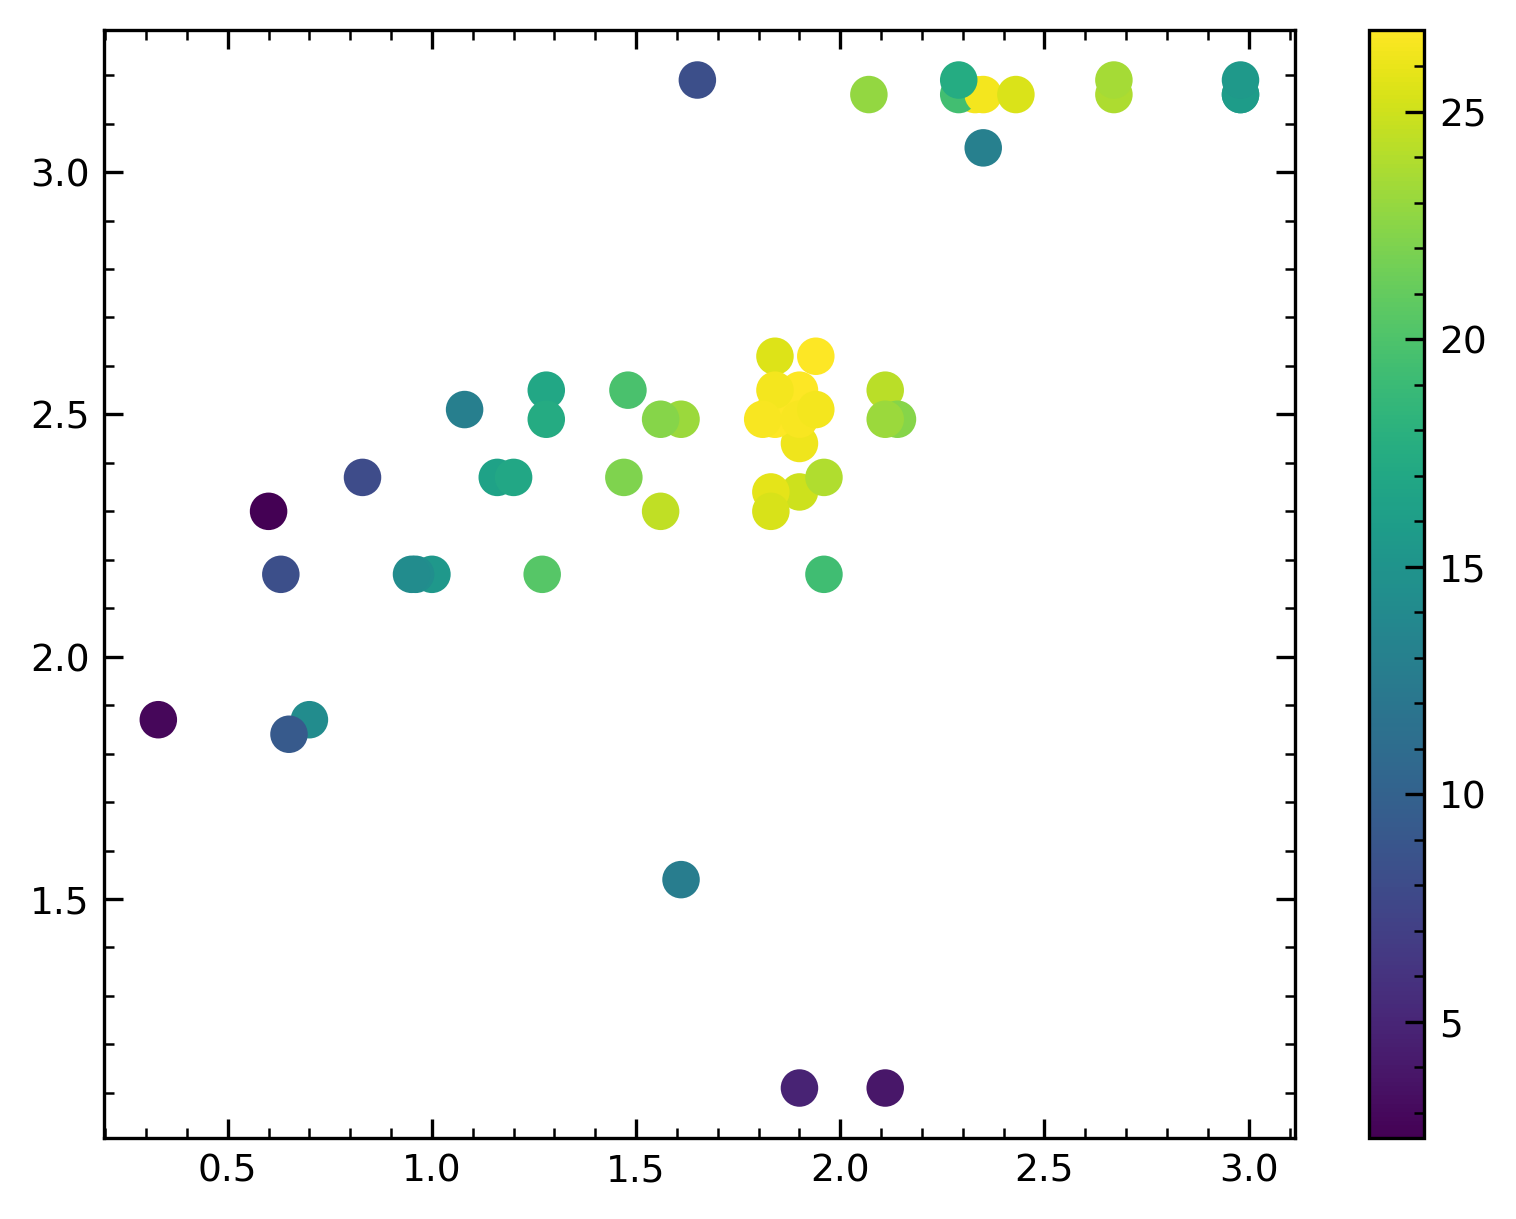

In [49]:
cdf = df[df['spacegroup']==221]
# cdf[cdf['formula'].str.contains("Au")]['A_X_diff'] = 2.3
# cdf[cdf['formula'].str.contains("Au")]['B_X_diff'] = 0.6
cdf.loc[72, 'A_X_ediff'] = 2.3
cdf.loc[72, 'B_X_ediff'] = 0.6
print(cdf[cdf['formula'].str.contains("Au")])
# cdf = cdf[cdf['tolerance_factor']>0.0]
# cdf = df.copy()
# scatter = plt.scatter(cdf['lostop_density'], cdf['elmd_density'], c=cdf['tolerance_factor'])
# scatter = plt.scatter(cdf['lostop_density'], cdf['elmd_density'], c=cdf['B_X_ediff'])
# scatter = plt.scatter(cdf['tolerance_factor'], cdf['lostop_density'], c=cdf['tolerance_factor'], vmin=0.9, vmax=1)
scatter = plt.scatter(cdf['B_X_ediff'], cdf['A_X_ediff'], c=cdf['lostop_density'])
cbar = fig.colorbar(mappable=scatter)
plt.show()

In [50]:
df.to_clipboard()

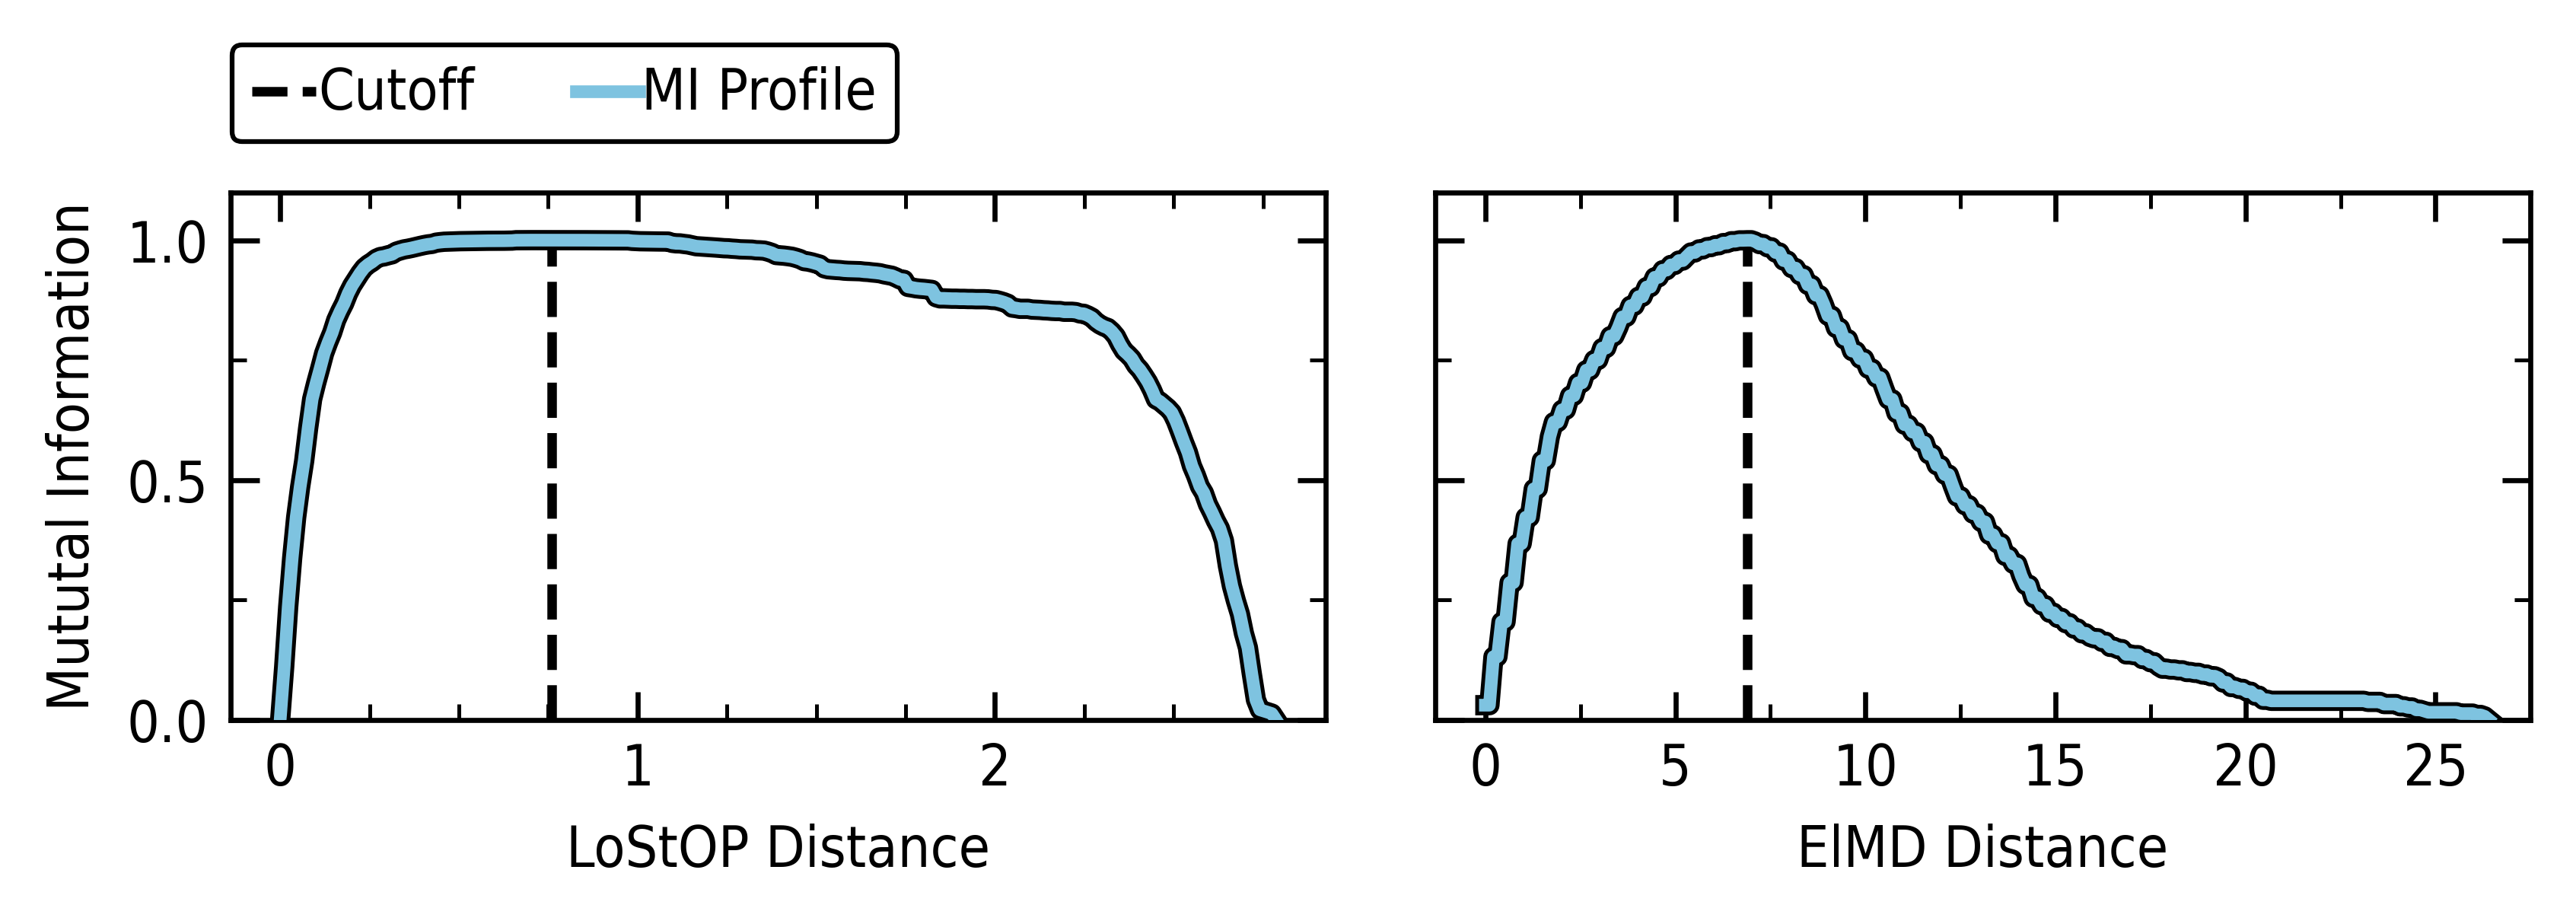

In [88]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5, 1.5), sharey=True, dpi=600)

# adjust the space between the subplots
plt.subplots_adjust(wspace=0.1)

# ax[0].add_patch(Rectangle((1.09, 0.0), 0.44, 1.1, color='k', alpha=0.1, lw=0))
# ax[0].add_patch(Rectangle((1.63, 0.0), 0.47, 1.1, color='k', alpha=0.1, lw=0))
# ax[0].add_patch(Rectangle((2.2, 0.0), 0.565, 1.1, color='k', alpha=0.1, lw=0))

ax[0].vlines(x=mi_data['lostop'][0], ymin=0, ymax=1.0, color='black', lw=1.5, ls='--', label='Cutoff')
ax[0].plot(np.linspace(0, np.max(lostop_dm), 250), mi_data['lostop'][1], zorder=10, color='black', lw=3.2,)
ax[0].plot(np.linspace(0, np.max(lostop_dm), 250), mi_data['lostop'][1], zorder=10, color='#7EC3E0', lw=2, label='MI Profile')
ax[0].set_yticks([0, 0.5, 1.0])
ax[0].set_ylim(0, 1.1)
ax[0].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax[0].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax[0].set_ylabel("Mututal Information")
ax[0].set_xlabel("LoStOP Distance")

# ax[1].add_patch(Rectangle((7.35, 0.0), 13.25, 1.1, color='k', alpha=0.1, lw=0))
# ax[1].add_patch(Rectangle((22.9, 0.0), 3.8, 1.1, color='k', alpha=0.1, lw=0))
ax[1].vlines(x=mi_data['elmd'][0], ymin=0, ymax=1, color='black', lw=1.5, ls='--', label='Cutoff')
ax[1].plot(np.linspace(0, np.max(elmd_dm), 250), mi_data['elmd'][1], zorder=10, color='black', lw=3.2,)
ax[1].plot(np.linspace(0, np.max(elmd_dm), 250), mi_data['elmd'][1], zorder=10, color='#7EC3E0', lw=2, label='MI Profile')
ax[1].set_xlim(None, 27.5)
ax[1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(2.5))
ax[1].set_xlabel("ElMD Distance")

legend = ax[0].legend(loc='lower center', fontsize=8, frameon=True, framealpha=1.0, labelspacing=0.25, bbox_to_anchor=(0.305, 1.0), ncol=2)
legend.get_frame().set_linewidth(0.75)


apply_condensed_font(fig)

plt.show()

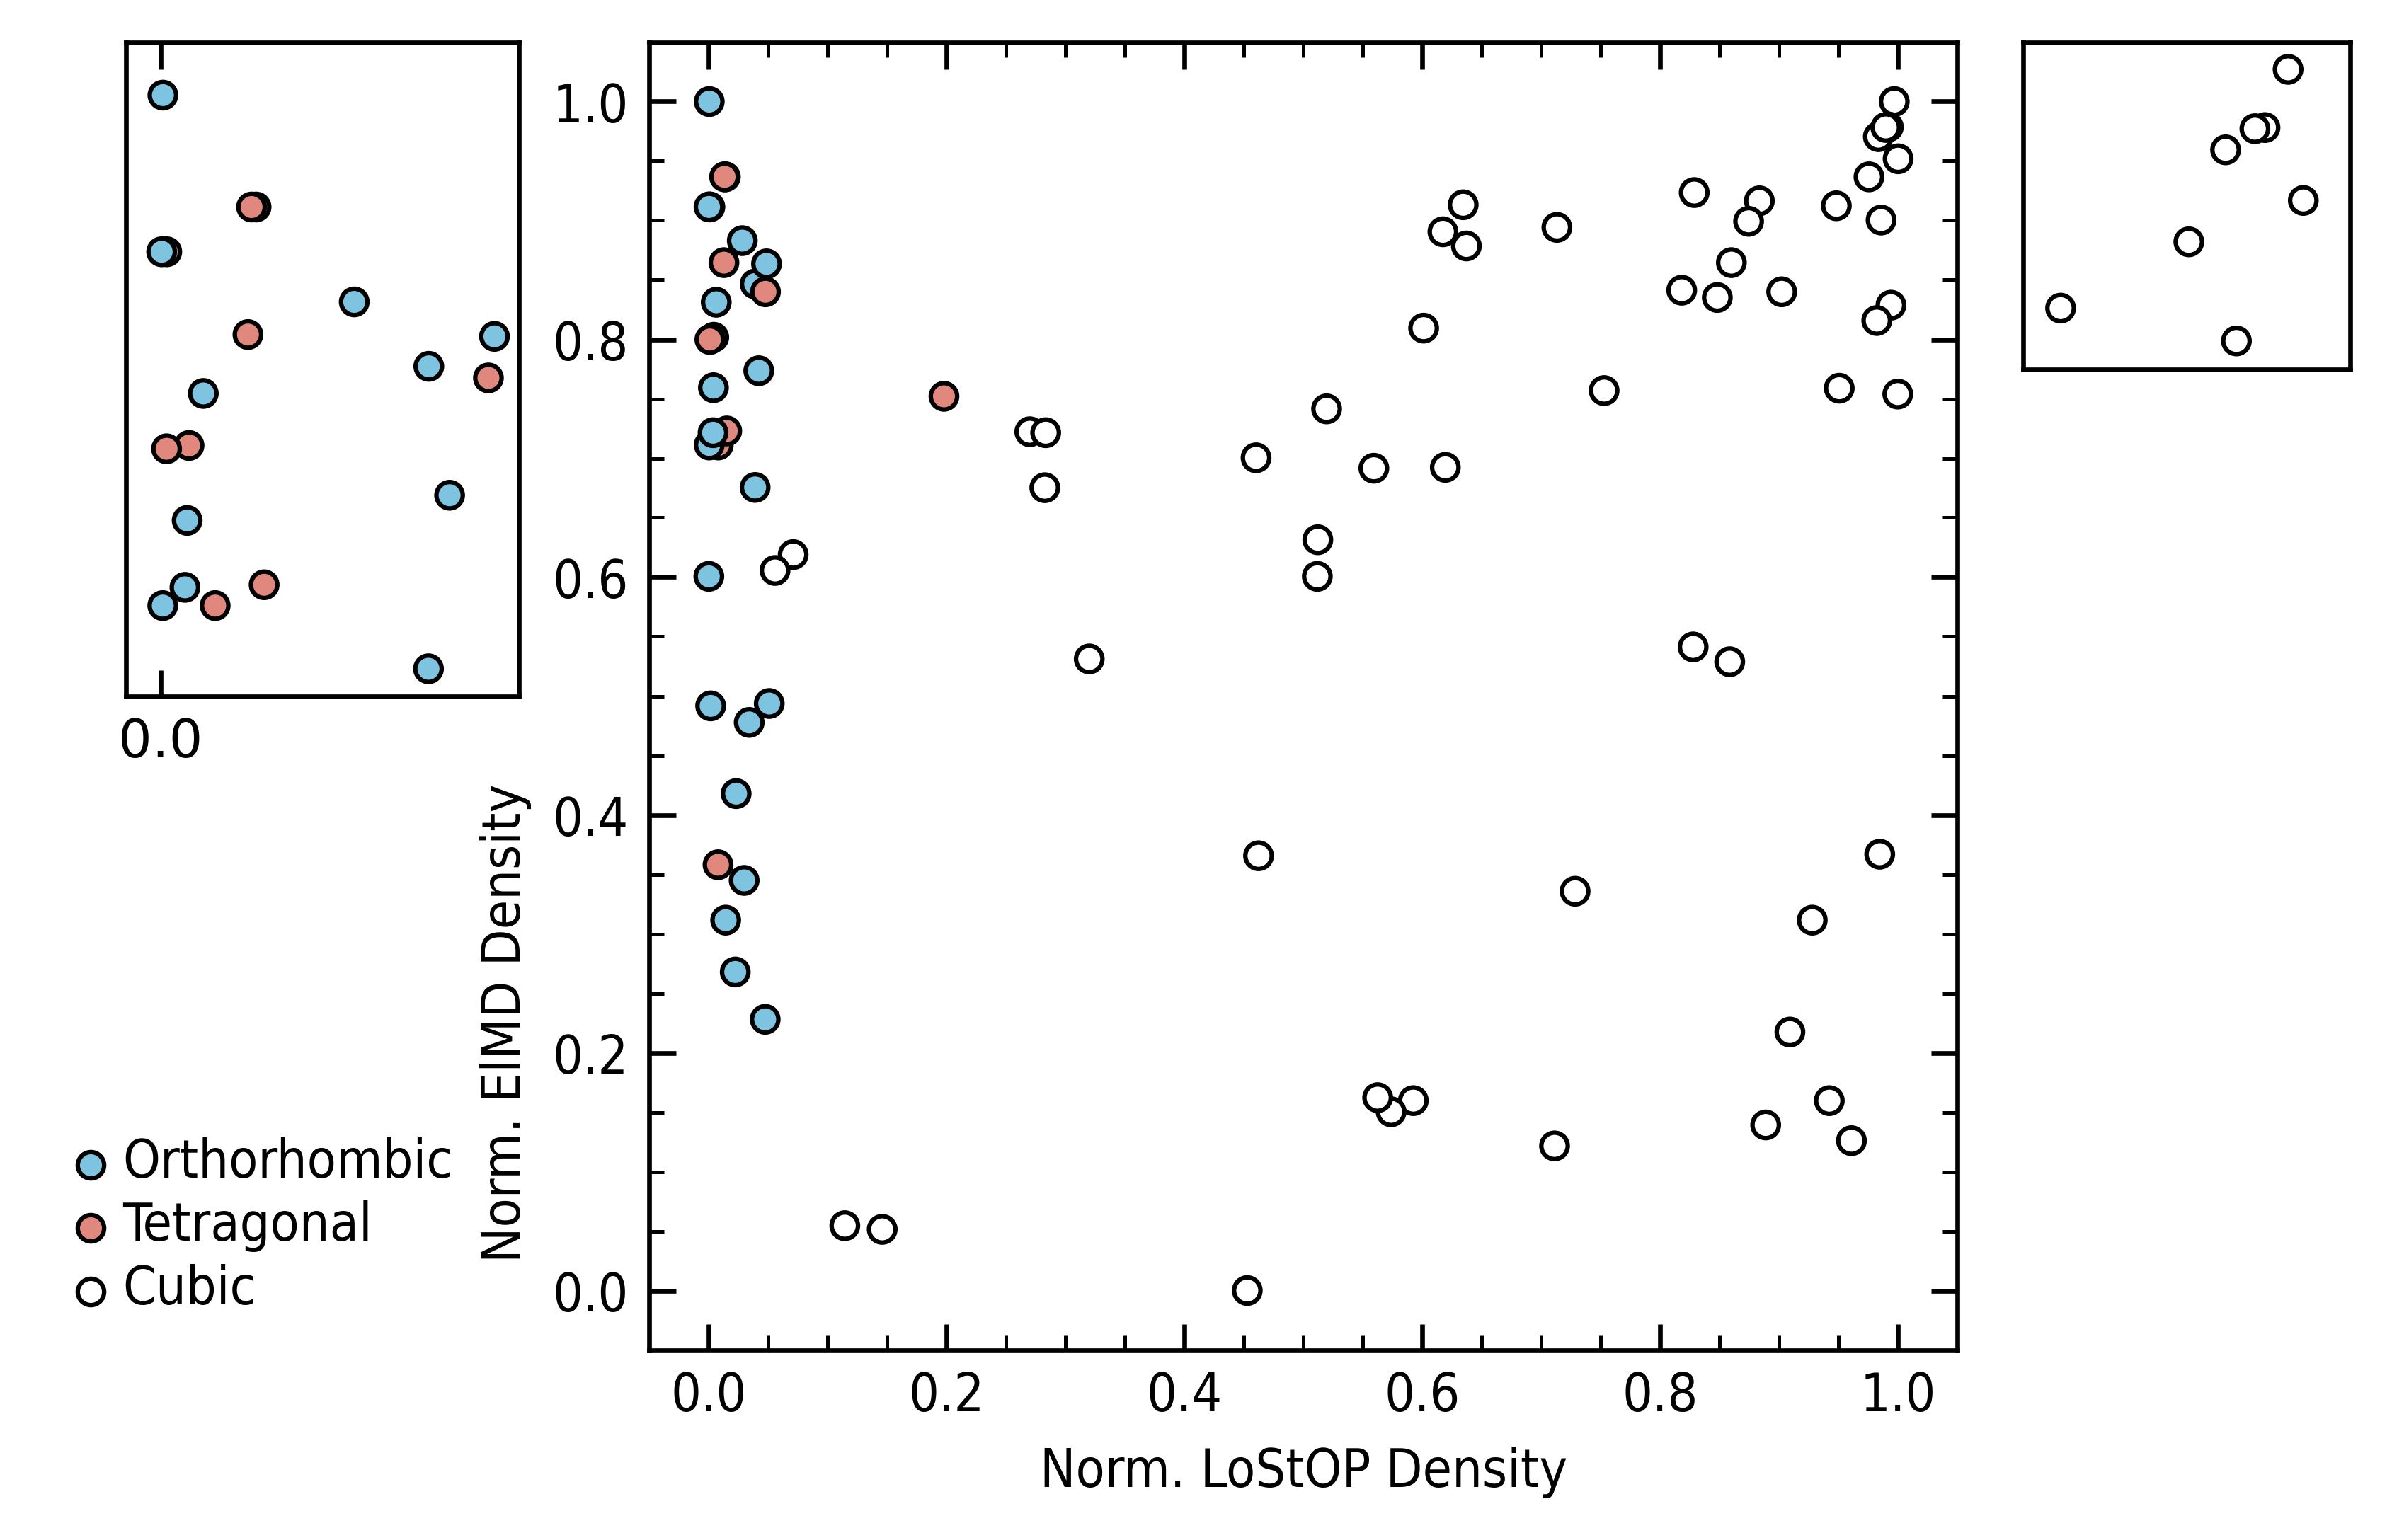

In [52]:
fig, ax = plt.subplots(figsize=(6.5, 4), dpi=600)
ax.set_aspect('equal')

scaled_df = df.copy()

# scale the scaled_df
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

p_idx = is_pareto_efficient(scaled_df[['lostop_density', 'elmd_density']].values, return_mask=False)
# pareto_labels = [labels[i] for i in p_idx]
pareto_x = scaled_df['lostop_density'].loc[p_idx]
pareto_y = scaled_df['elmd_density'].loc[p_idx]
pareto_x, pareto_y = zip(*sorted(zip(pareto_x, pareto_y), key=lambda pair: pair[1]))
# ax.plot(pareto_x, pareto_y, color='k', lw=1.5, ls='-', marker='None', label='Pareto Front')

cmap = mpl.colors.ListedColormap(["#7EC3E0", "#E0877E", "#FFF"]) # blue, red, white, ortho, tet, cube

ax.scatter(scaled_df['lostop_density'], scaled_df['elmd_density'], c=scaled_df['spacegroup'], cmap=cmap, s=20, zorder=9, lw=0.75, ec='k')

ax.scatter([],[], c='#7EC3E0', label='Orthorhombic', s=20, zorder=9, lw=0.75, ec='k')
ax.scatter([],[], c='#E0877E', label='Tetragonal', s=20, zorder=9, lw=0.75, ec='k')
ax.scatter([],[], c='#FFF', label='Cubic', s=20, zorder=9, lw=0.75, ec='k')

ax.set_xlabel("Norm. LoStOP Density", loc='center')
ax.set_ylabel("Norm. ElMD Density")
ax.yaxis.set_label_coords(-0.09, 0.25)

# get axis limits
ax_xlim = ax.get_xlim()
ax_ylim = ax.get_ylim()

# create left inset axes
axins_left = ax.inset_axes(
    [-0.4, 0.5, 0.3, 0.5],
    xlim=(-0.005, 0.052), 
    ylim=(0.66, 1.03), 
    yticks=[],
    xticks=[0.0],
    xticklabels=["0.0"],
    yticklabels=[])

axins_left.tick_params(axis='both', which='minor', length=0)
axins_left.scatter(scaled_df['lostop_density']+1e-10, scaled_df['elmd_density'], c=scaled_df['spacegroup'], cmap=cmap, s=20, zorder=9, lw=0.75, ec='k')
# ax.indicate_inset_zoom(axins_left, edgecolor="black", alpha=1.0, lw=0.75)

# create right inset axes
axins_right = ax.inset_axes(
    [1.05, 0.75, 0.25, 0.25],
    xlim=(0.94, 1.01), 
    ylim=(0.89, 1.01), 
    yticks=[],
    xticks=[],
    xticklabels=[],
    yticklabels=[])
axins_right.tick_params(axis='both', which='minor', length=0)
axins_right.scatter(scaled_df['lostop_density'], scaled_df['elmd_density']+1e-10, c=scaled_df['spacegroup'], cmap=cmap, s=20, zorder=9, lw=0.75, ec='k')
# ax.indicate_inset_zoom(axins_right, edgecolor="black", alpha=1.0, lw=0.75)


# legend = plt.legend(loc='lower left', fontsize=8, frameon=True, framealpha=1.0, labelspacing=0.25, bbox_to_anchor=(1.0275, -0.024))
legend = plt.legend(loc='lower left', fontsize=8, frameon=False, framealpha=1.0, labelspacing=0.25, bbox_to_anchor=(-0.5, -0.024))
legend.get_frame().set_linewidth(0.75)
apply_condensed_font(fig)
plt.show()

In [86]:
# formula, mp-id, lostop_density, elmd_density

formulae = [formula.split("]")[1].split("_")[0] for formula in scaled_df['filename'].to_list()]
formulae = [formula.replace("3", "$_3$") for formula in formulae]

mp_id = [formula.split("_")[1].split(".")[0] for formula in scaled_df['filename'].to_list()]

table_df = pd.DataFrame([formulae, mp_id]).T
table_df.columns = ["Formula", "MP-ID"]
table_df['ElMD Density'] = scaled_df['elmd_density'].to_list()
table_df['LoStOP Density'] = scaled_df['lostop_density'].to_list()
table_df = table_df.round(4)
table_df.to_clipboard()

In [53]:
print("tetragonal", scaled_df[scaled_df['spacegroup'] == 140]['lostop_density'].median())
print("orthorhombic", scaled_df[scaled_df['spacegroup'] == 62]['lostop_density'].median())

tetragonal 0.010316921416562055
orthorhombic 0.022204429048270122


In [54]:
scaled_df.to_clipboard()

In [55]:
scaled_df['combined_score'] = scaled_df['lostop_density'] + scaled_df['elmd_density']

scaled_df['log_volume'] = np.log(scaled_df['volume'])

scaled_df.to_clipboard()

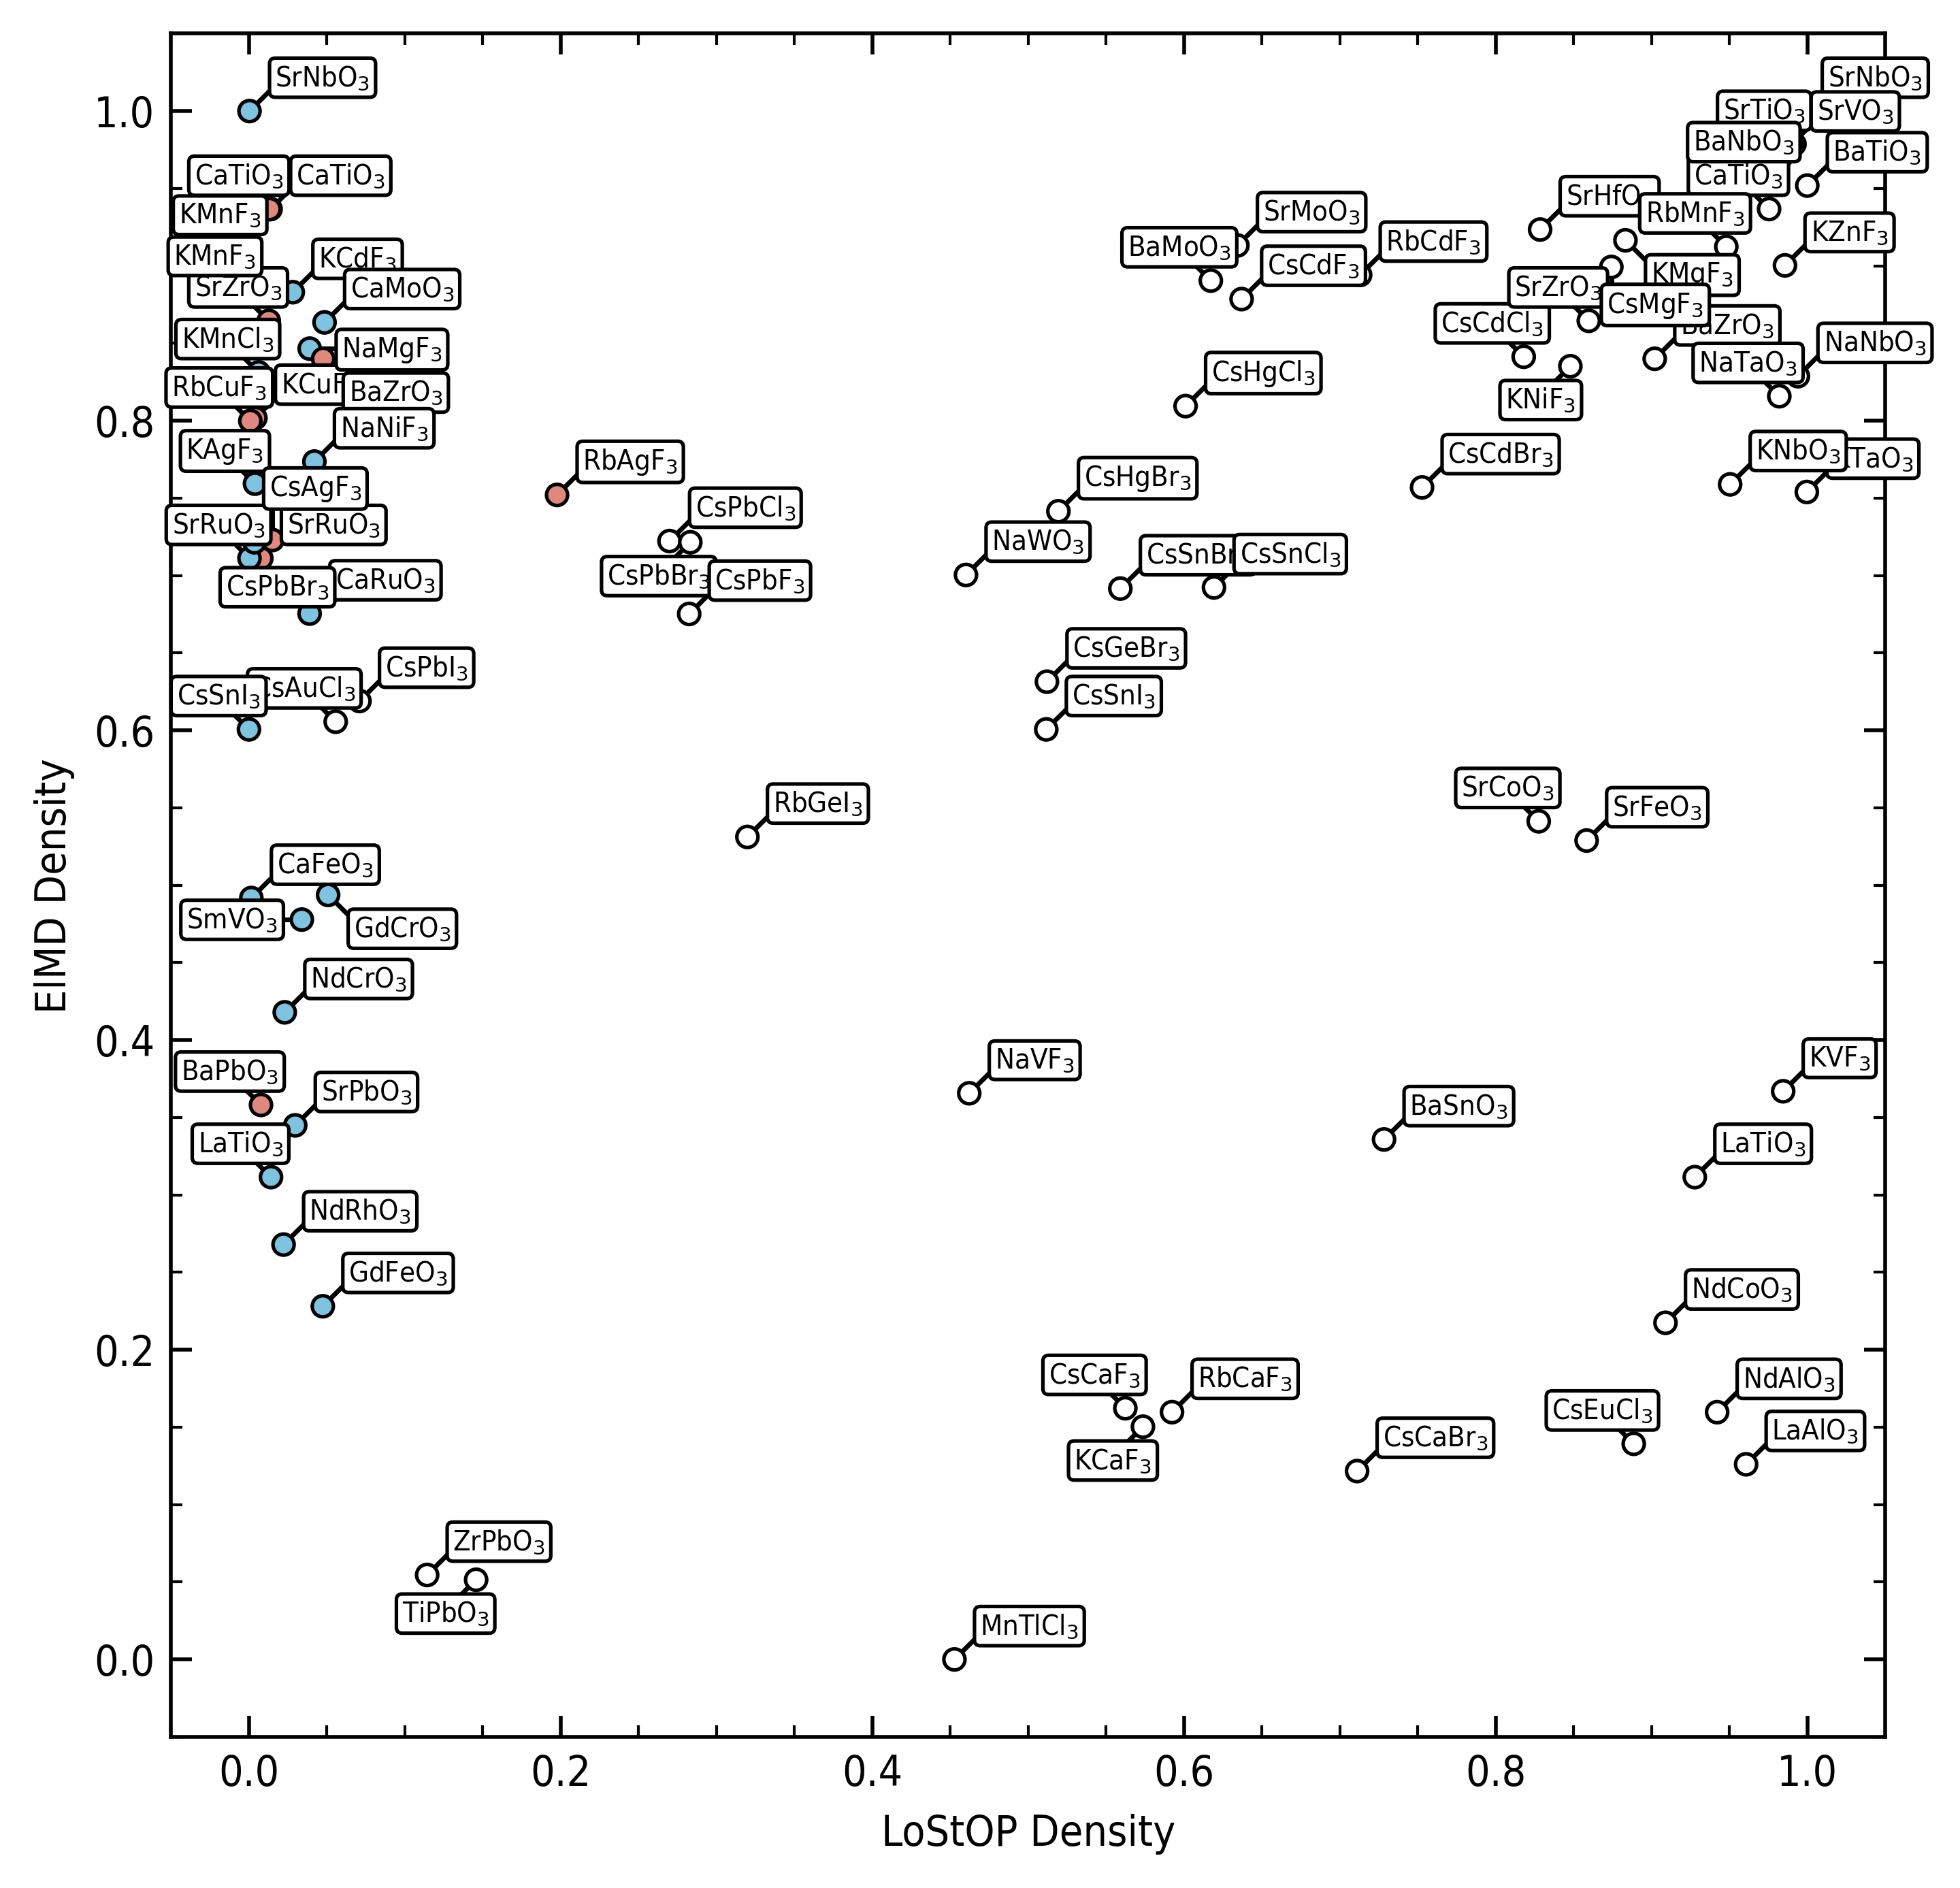

In [70]:
# plt.rcParams['font.size'] = 3
# plt.rcParams.update({'font.size': 3})

scaled_df = df.copy()

# scale the scaled_df
scaled_df[['lostop_density', 'elmd_density']] = MinMaxScaler().fit_transform(scaled_df[['lostop_density', 'elmd_density']])

# get some nice formula labels
labels = [reduce_single_formula(formula) for formula in scaled_df['formula'].values]
# for i, label in enumerate(labels):
#     if "[" in data['filename'].values[i]:
#         labels[i] = "$_{" + data['filename'].values[i].split(']')[0].split('[')[1] + "}$" + str(label)

fig, ax = plt.subplots(figsize=(6.5, 6.5), dpi=500)

# find the pareto optimal points and plot the front
p_idx = is_pareto_efficient(scaled_df[['lostop_density', 'elmd_density']].values, return_mask=False)
pareto_labels = [labels[i] for i in p_idx]
pareto_x = scaled_df['lostop_density'].loc[p_idx]
pareto_y = scaled_df['elmd_density'].loc[p_idx]
pareto_x, pareto_y = zip(*sorted(zip(pareto_x, pareto_y), key=lambda pair: pair[1]))
# ax.plot(pareto_x, pareto_y, color='C1', lw=1, ls=':', marker='None')

cmap = mpl.colors.ListedColormap(["#7EC3E0", "#E0877E", "#FFF"]) # blue, red, white, ortho, tet, cube
ax.scatter(scaled_df['lostop_density'], scaled_df['elmd_density'], c=scaled_df['spacegroup'], cmap=cmap, s=20, zorder=9, lw=0.75, ec='k')


# adjust "font.size": 9, to 5


ta.allocate(ax,
            x=scaled_df['lostop_density'],
            y=scaled_df['elmd_density'],
            text_list=labels,
            x_scatter=scaled_df['lostop_density'].values,
            y_scatter=scaled_df['elmd_density'].values,
            x_lines=[pareto_x],
            y_lines=[pareto_y],
            textsize=3,
            min_distance=0.015,
            max_distance=0.07,
            nbr_candidates=1000,
            linecolor='k',
            avoid_crossing_label_lines=True,
            avoid_label_lines_overlap=True,
            bbox=dict(boxstyle="round", fc="w", ec="k", pad=0.2, lw=0.75),
            zorder=15,
            )

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)


# Set labels
ax.set_xlabel("LoStOP Density")
ax.set_ylabel("ElMD Density")
apply_condensed_font(fig)
# plt.rcParams['font.size'] = 3
# plt.rcParams.update({'font.size': 3})
# save as svg
plt.savefig("/Users/andrewf/Desktop/MINOV Figures/perovskite_pareto.svg", dpi=600)

In [57]:
scaled_df['combined_score'] = scaled_df['lostop_density'] + scaled_df['elmd_density']

scaled_df['log_volume'] = np.log(scaled_df['volume'])



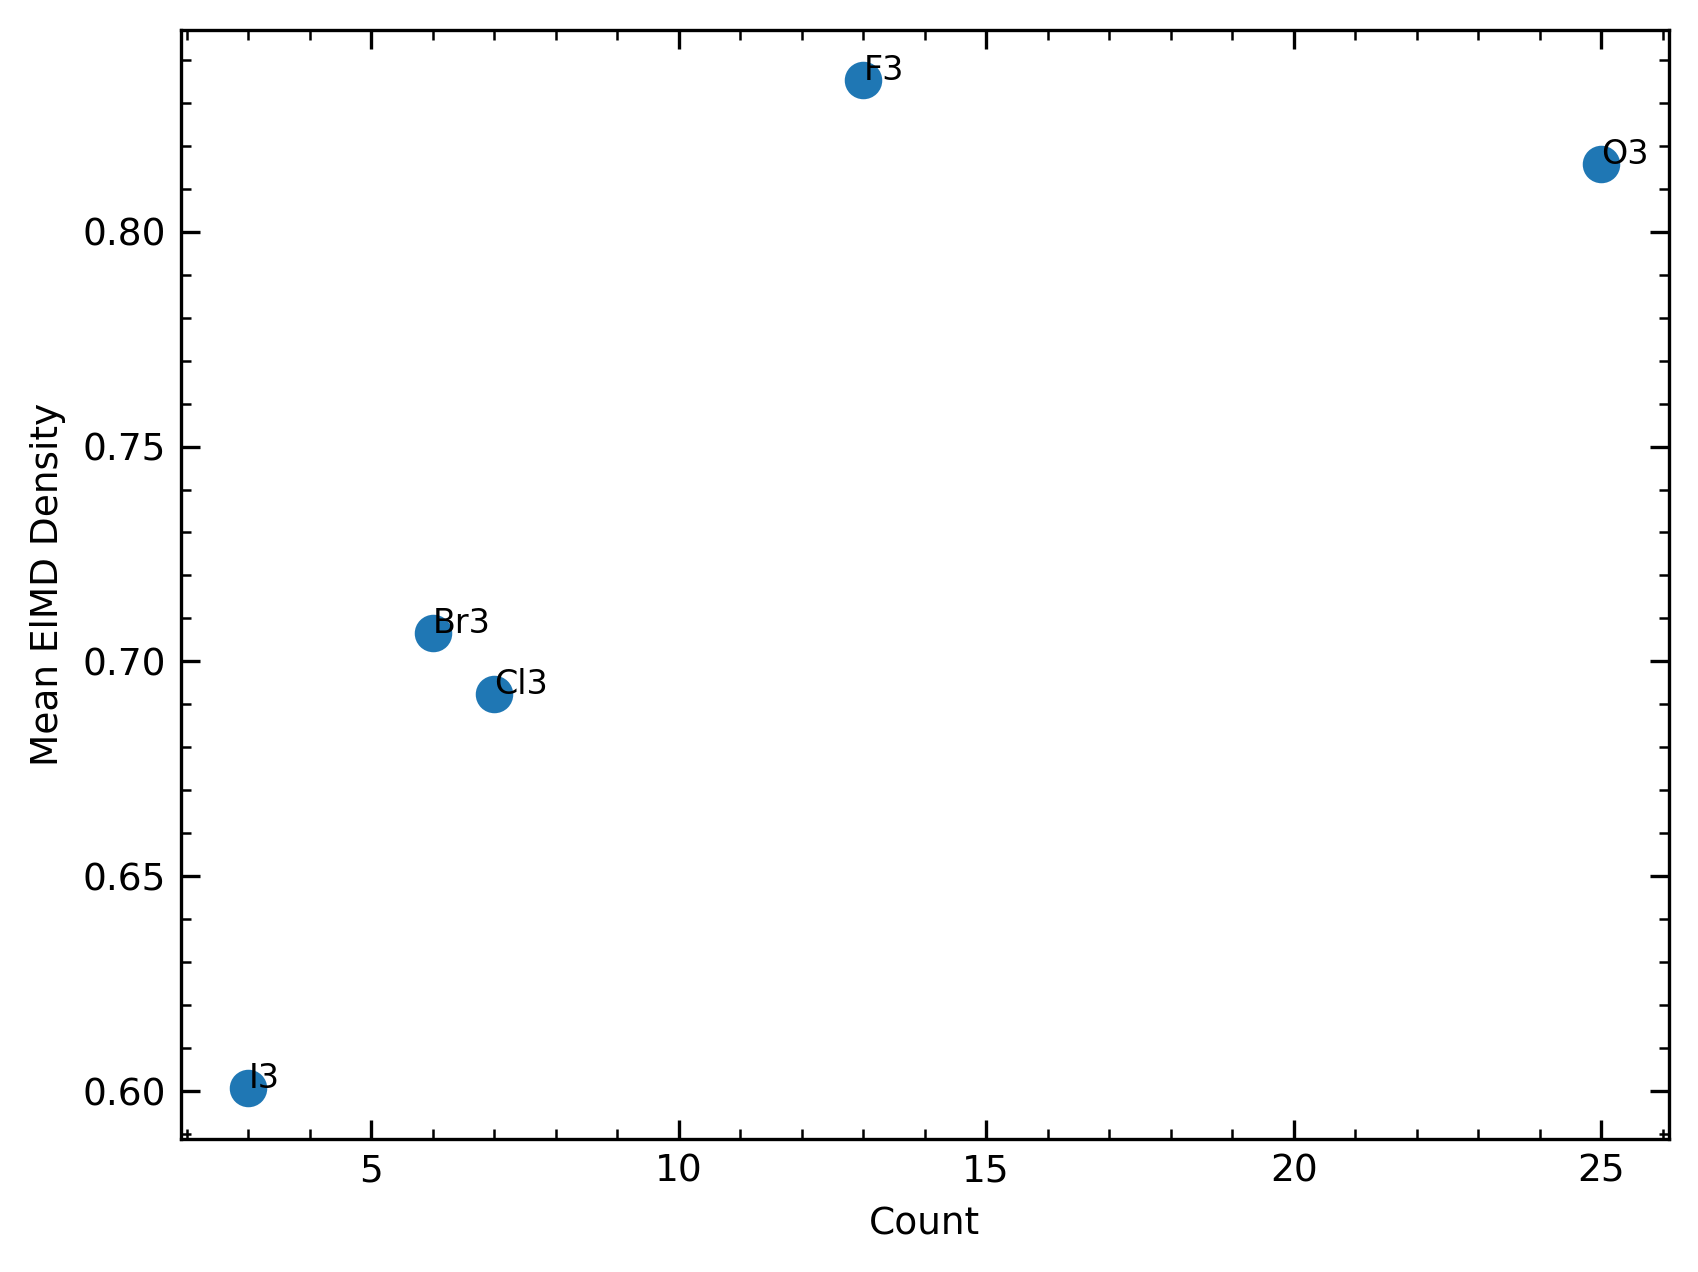

['O3', 'Cl3', 'F3', 'Br3', 'I3'] [0.8158229121755889, 0.6923398449841457, 0.8352021233668727, 0.7065547485268608, 0.6006596945255728] [25, 7, 13, 6, 3]


In [58]:
# scaled_df[scaled_df['lostop_density']==1.0]

units = ['O3', "Cl3", "F3", "Br3", "I3"]
means = []
medians = []
counts = []

for unit in units:
    means.append(scaled_df[scaled_df['formula'].str.contains(unit)]['elmd_density'].mean())
    medians.append(scaled_df[scaled_df['formula'].str.contains(unit)]['elmd_density'].median())
    counts.append(scaled_df[scaled_df['formula'].str.contains(unit)]['elmd_density'].count())

# plt.scatter(counts, means)
plt.scatter(counts, medians)
# annotate with unit
for i, unit in enumerate(units):
    plt.annotate(unit, (counts[i], medians[i]), fontsize=8)
plt.xlabel("Count")
plt.ylabel("Mean ElMD Density")
plt.show()

print(units, medians, counts)


In [59]:
# 4/86
(12+5+5)/86

0.2558139534883721

In [60]:
scaled_df[scaled_df['spacegroup']==62]
scaled_df[scaled_df['spacegroup']==62][['formula', 'lostop_density']].to_clipboard()

Attempting to correct my cifs

In [61]:
import pandas as pd
from collections import Counter
import re

def extract_elements(df, column_name='formula'):
    # Regular expression to find elements (capital letter followed by optional lowercase letters)
    element_pattern = re.compile(r'([A-Z][a-z]*)')
    
    # List to store all elements
    all_elements = []
    
    # Iterate through each formula in the column
    for formula in df[column_name]:
        # Find all elements in the formula
        elements = element_pattern.findall(formula)
        all_elements.extend(elements)
    
    # Count occurrences of each element
    element_counts = Counter(all_elements)
    
    return all_elements, element_counts


# Extract elements and count them
elements_list, element_counts = extract_elements(scaled_df)
element_counts = dict(element_counts)

print(element_counts["Tl"])

scaled_df[scaled_df['formula'].str.contains("Cl3")]


1


,lostop_density,elmd_density,formula,filename,spacegroup,volume,CN2,dists,tolerance_factor,A_X_ediff,B_X_ediff,combined_score,log_volume
6,0.818027,0.841325,Cs1 Cd1 Cl3,[cub]CsCdCl3_mp-568544.cif,221,145.897233,0.484875,3.722494,0.891569,2.37,1.47,1.659352,4.982902
15,0.601034,0.809442,Cs1 Hg1 Cl3,[cub]CsHgCl3_mp-570591.cif,221,157.708370,0.445877,3.820351,0.869516,2.37,1.16,1.410476,5.060748
22,0.619266,0.692340,Cs1 Sn1 Cl3,[cub]CsSnCl3_mp-1070375.cif,221,172.323849,0.451567,3.934898,0.863415,2.37,1.20,1.311606,5.149376
25,0.269877,0.722304,Cs1 Pb1 Cl3,[cub]CsPbCl3_mp-23037.cif,221,183.235408,0.397631,4.016257,0.820244,2.37,0.83,0.992180,5.210772
48,0.888636,0.139258,Cs1 Eu1 Cl3,[cub]CsEuCl3_mp-1068377.cif,221,178.752300,0.530436,3.983232,0.825749,2.37,1.96,1.027894,5.186001
72,0.055660,0.605615,Cs1 Au1 Cl3,[cub]CsAuCl3_mp-23026.cif,221,141.163022,0.343225,3.681787,NaN,NaN,NaN,0.661275,4.949915
82,0.452729,0.000000,Mn1 Tl1 Cl3,[cub]MnTlCl3_mp-570290.cif,221,130.267789,0.566026,3.584517,0.886562,1.54,1.61,0.452729,4.869592


In [62]:
scaled_df[scaled_df['lostop_density']==0.0]

,lostop_density,elmd_density,formula,filename,spacegroup,volume,CN2,dists,tolerance_factor,A_X_ediff,B_X_ediff,combined_score,log_volume
78,0.0,0.60066,Cs4 Sn4 I12,[ortho]CsSnI3_mp-27381.cif,62,956.318709,0.148415,4.787836,inf,1.87,0.7,0.60066,6.863091


In [63]:
print(np.sort(lostop_dm[26])[:3])
print(np.sort(lostop_dm[52])[:3])

[0.         0.00264812 0.00471504]
[0.         0.01027159 0.01578145]


In [64]:
scaled_df[scaled_df['spacegroup']==62]

,lostop_density,elmd_density,formula,filename,spacegroup,volume,CN2,dists,tolerance_factor,A_X_ediff,B_X_ediff,combined_score,log_volume
5,0.022962,0.417927,Nd4 Cr4 O12,[ortho]NdCrO3_mp-19269.cif,62,231.447699,0.140937,4.442617,inf,2.30,1.78,0.440888,5.444354
12,0.014154,0.311500,La4 Ti4 O12,[ortho]LaTiO3_mp-22013.cif,62,250.787147,0.204686,2.528410,inf,2.34,1.90,0.325654,5.524605
13,0.001527,0.491736,Ca4 Fe4 O12,[ortho]CaFeO3_mp-19115.cif,62,210.959582,0.194516,4.525373,inf,2.44,1.61,0.493263,5.351667
16,0.013880,0.936708,Ca4 Ti4 O12,[ortho]CaTiO3_mp-4019.cif,62,224.099738,0.180329,2.670761,inf,2.44,1.90,0.950588,5.412091
19,0.047382,0.228083,Gd4 Fe4 O12,[ortho]GdFeO3_mp-600576.cif,62,232.211129,0.058323,4.344901,inf,2.24,1.61,0.275466,5.447647
21,0.028134,0.883020,K4 Cd4 F12,[ortho]KCdF3_mp-9628.cif,62,324.862947,0.128558,5.270724,inf,3.16,2.29,0.911154,5.783403
23,0.038918,0.675437,Ca4 Ru4 O12,[ortho]CaRuO3_mp-20947.cif,62,227.743309,0.028345,4.647918,inf,2.44,1.24,0.714355,5.428219
24,0.006214,0.831215,K4 Mn4 Cl12,[ortho]KMnCl3_mp-23049.cif,62,494.008599,0.222589,5.964363,inf,2.34,1.61,0.837429,6.202553
30,0.050792,0.493736,Gd4 Cr4 O12,[ortho]GdCrO3_mp-18331.cif,62,224.595168,0.098782,4.330599,inf,2.24,1.78,0.544528,5.414300
31,0.029694,0.344939,Sr4 Pb4 O12,[ortho]SrPbO3_mp-20489.cif,62,296.903770,0.008072,2.970533,inf,2.49,1.11,0.374633,5.693408
